##### Copyright 2024 Google LLC.

In [20]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Using LangChain’s multimodal chain with Gemini

Combining Gemini models with third-party frameworks can be useful for many use cases.

In this notebook, you will learn to input multimodal data (images and text) directly into the model through [LangChain](https://python.langchain.com/v0.2/docs/introduction/).

----------------

Imagine your app requires users to submit specific information, such as a picture of their signature on a particular background.

- You want Gemini model to analyze the content of the image;
- Verify if the signature is handwritten;
- Determine what color is the background.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/langchain/Using LangChain’s_multimodal_chain_with_Gemini.ipynb"><img src = "https://www.tensorflow.org/images/colab_logo_32px.png"/>Run in Google Colab</a>
  </td>
</table>

## Install dependencies

In [21]:
!pip install -U -q langchain==0.2.14 langchain-community langchain-google-genai==1.0.6

In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

from IPython.display import Image, Markdown, display
import requests

## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.


In [23]:
import os
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Download images

First, you need to download images. For demonstration purposes, Franklin D. Roosevelt's signature and Gemini logo will be used.

In [24]:
def display_image(image_path: str) -> None:
    """helper function for displaying images"""
    display(Image(filename=image_path, width = 500))

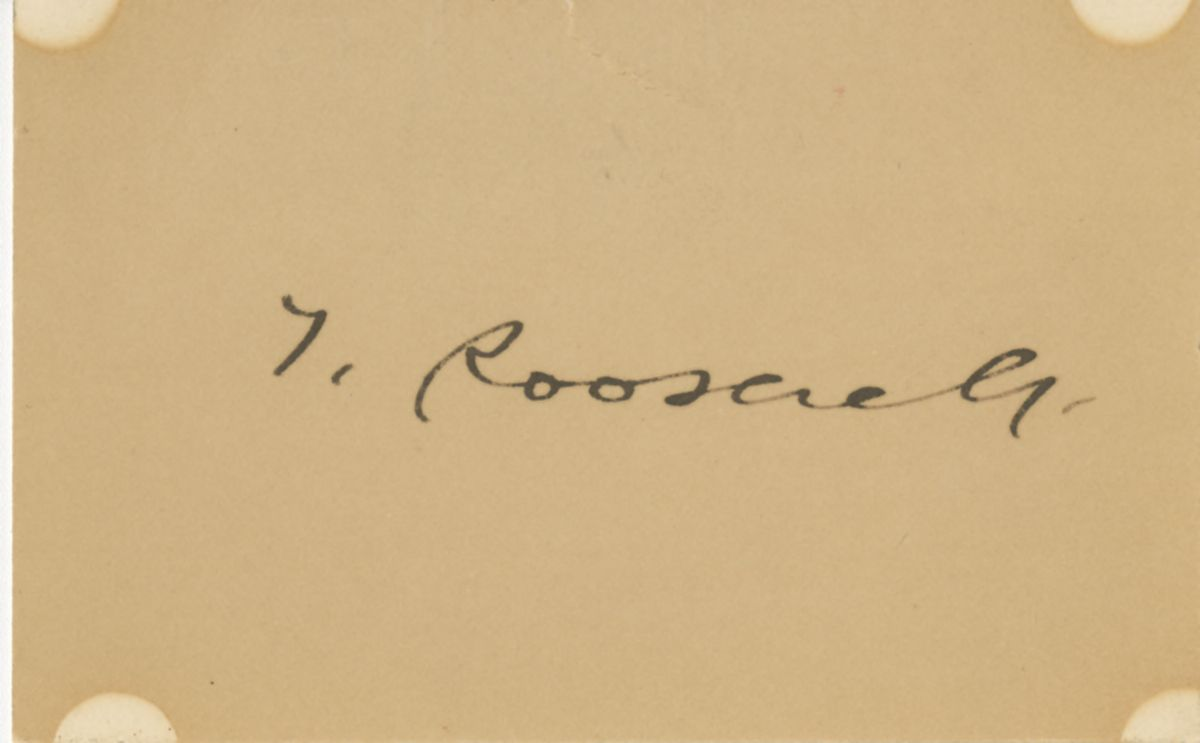

In [25]:
signature_url = "https://upload.wikimedia.org/wikipedia/commons/6/6e/Autograph_Collection_-_Roosevelt%2C_Theodore%2C_1858-1919_-_DPLA_-_32bb680566dca1786891bc0751fe9ecd_%28page_2%29.jpg"

signature_image_path = "/content/roosevelt_signature.jpg"
!curl -s -o {signature_image_path} {signature_url}

display_image(signature_image_path)

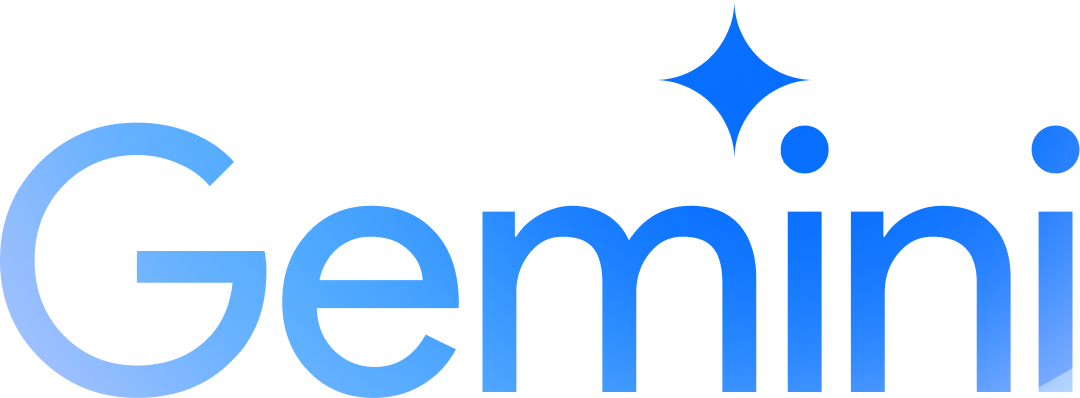

In [26]:
gemini_url = "https://upload.wikimedia.org/wikipedia/commons/4/45/Gemini_language_model_logo.png"

gemini_image_path = "/content/gemini_logo.jpg"
!curl -s -o {gemini_image_path} {gemini_url}

display_image(gemini_image_path)

## Define Gemini Model and integrate it with LangChain.

 Here, Langchain's `HumanMessage` is created from two components: a text prompt and a path to the downloaded image. Then, the `HumanMessage` is passed to `ChatGoogleGenerativeAI` (a class that integrates Gemini API with langchain) to receive a response from a Gemini model.

In [27]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

In [28]:
def extract_text(image_path: str) -> None:
    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "What is written in this sign?",
            },
            {"type": "image_url", "image_url": image_path},
        ]
    )
    response = llm.invoke([message])
    return Markdown(response.content)

In [29]:
extract_text(signature_image_path)

T. Roosevelt.

In [30]:
extract_text(gemini_image_path)

Gemini.

## Tool calling

LangChain provides tool calling, which allows the model to respond to a prompt by generating output that matches a user-defined schema.

A tool call includes a name, an argument dictionary, and an optional identifier.

Here are two tool declarations: `print_text_type` and `print_text_color`. While these functions can be called, in this case their job is just to provide the model with output schema and information about when each one should be used.

In [31]:
def print_text_type(handwritten: bool):
    """Prints whether the text in the given image is handwritten or not."""
    print(handwritten)

def print_text_color(color: str):
    """Prints what color is the text in the image."""
    print(color)

Update your model declaration to utilize tools.

In [32]:
llm = llm.bind_tools([print_text_type, print_text_color])

You can now call the model who will use your tools depending on what you are asking it.

In [33]:
def is_image_handwritten(image_path: str) -> dict:
    message = HumanMessage(
    content=[
            {"type": "text", "text": "Is it handwritten?"},
            {"type": "image_url", "image_url": {"url": image_path}},
        ],
    )
    response = llm.invoke([message])
    return response.tool_calls[0]

In [34]:
is_image_handwritten(signature_image_path)

{'name': 'print_text_type',
 'args': {'handwritten': True},
 'id': 'ebad2d05-fd5d-4d28-8158-191081837827',
 'type': 'tool_call'}

In [35]:
is_image_handwritten(gemini_image_path)

{'name': 'print_text_type',
 'args': {'handwritten': False},
 'id': 'f2ce025a-5070-43fa-9c2e-d1d8da288757',
 'type': 'tool_call'}

In [36]:
def get_image_background_color(image_path: str) -> dict:
    message = HumanMessage(
    content=[
            {"type": "text", "text": "What color is the text in the image?"},
            {"type": "image_url", "image_url": {"url": image_path}},
        ],
    )
    response = llm.invoke([message])
    return response.tool_calls[0]

In [37]:
get_image_background_color(signature_image_path)

{'name': 'print_text_color',
 'args': {'color': 'black'},
 'id': '060d13ae-2886-4f84-a25e-3e218b2357b7',
 'type': 'tool_call'}

In [38]:
get_image_background_color(gemini_image_path)

{'name': 'print_text_color',
 'args': {'color': 'blue'},
 'id': '5d5f46f9-7d3c-494e-8945-df6fabcc1aef',
 'type': 'tool_call'}

Because of function calling, not only are the outputs consistently formatted, but they also include correct types.

## Summary
In this notebook, you have learned:

- Integration of LangChain and the Gemini API
- Utilization of tool calls

Everything shown in this notebook could be done using just the Gemini API library, however, many potential use cases would benefit from Langchain, e.g. a [chatbot with access to a database](https://github.com/google-gemini/cookbook/blob/main/examples/langchain/Chat_with_SQL_using_langchain.ipynb).

### Related examples

If you want to see more of what Langchain has to offer you can also check out their [tutorials](https://python.langchain.com/v0.2/docs/tutorials/) and [other LangChain related notebooks](https://github.com/google-gemini/cookbook/tree/main/examples/langchain/) from [Gemini cookbook](https://github.com/google-gemini/cookbook).
